# __Prueba técnica - Skandia__
Juan Sebastian Moncada Aguilar

### 1. Generar una conexión a la base de datos en python usando las librerías necesarias para la conexión (Los accesos y URL son enviados en el correo de citación).

In [89]:
import pyodbc
print(pyodbc.drivers())

['SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'ODBC Driver 18 for SQL Server']


In [90]:
import matplotlib.pyplot as plt
import os
import plotly.express as px
import pyodbc
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
from dotenv import load_dotenv

"""
La conexión a la base de datos es realizada a través de un archivo .env, el cual es un archivo de texto que contiene las credenciales
proporcionadas por Skandia para conectarse a la base de datos. Esto se hace como buena practica, con el fin de no dejar
expuestos en el notebook usuarios y contraseñas.
"""

load_dotenv()

server = os.getenv('SERVER')
database = os.getenv('DATABASE')
username = os.getenv('USERNAME')
password = os.getenv('PASS')

# Establecer conexión
conn = pyodbc.connect(
    f'DRIVER={{ODBC Driver 18 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

In [91]:
table_dict = {}

tables = pd.read_sql("SELECT table_name FROM information_schema.tables WHERE table_type='BASE TABLE'", conn)

for table in tables['table_name']:
    df = pd.read_sql(f'SELECT * FROM {table}', conn)
    table_dict[table] = df

C:\Users\JUANC\AppData\Local\Temp\ipykernel_25192\2275870044.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JUANC\AppData\Local\Temp\ipykernel_25192\2275870044.py:6: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [92]:
table_dict.keys()

dict_keys(['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track'])

In [93]:
album_df = table_dict['Album'] # Cuantos albumes, artistas + comunes
artist_df = table_dict['Artist']
customer_df = table_dict['Customer'] # Cuantos clientes hay, quienes son los + frecuentes.
employee_df = table_dict['Employee']
genre_df = table_dict['Genre']
invoice_df = table_dict['Invoice'] # Total vendido, paises con + ventas
invoiceline_df = table_dict['InvoiceLine']
mediatype_df = table_dict['MediaType']
playlist_df = table_dict['Playlist']
pltrack_df = table_dict['PlaylistTrack']
track_df = table_dict['Track']

In [94]:
inventory_df = track_df.merge(album_df, how='left', on='AlbumId') \
                       .merge(artist_df, how='left', on='ArtistId') \
                       .merge(genre_df, how='left', on='GenreId')

inventory_df = inventory_df.rename(columns={
                                     'Name_x': 'Track',
                                     'Name_y': 'Artist',
                                     'Name': 'Genre'  
                                   })

inventory_df.set_index('TrackId', inplace=True)

inventory_df['Minutes'] = inventory_df['Milliseconds']/(60*1000)

In [95]:
sales_df = invoice_df.merge(invoiceline_df, how='left', on = 'InvoiceId')\
                    .merge(inventory_df, how='left', on='TrackId')
sales_df['Total'] = sales_df['UnitPrice_y']

# Cluster

In [96]:
# Frecuencia de compra

sales_df['InvoiceDate'] = pd.to_datetime(sales_df['InvoiceDate'])
sales_df.sort_values(by=['CustomerId', 'InvoiceDate'], inplace=True)

sales_df['Purchase_Difference'] = sales_df.groupby('CustomerId')['InvoiceDate'].diff().dt.days
median_frequency = sales_df['Purchase_Difference'].median()

customer_frequency = sales_df.groupby('CustomerId').agg({
    'Purchase_Difference': lambda x: x.mean() if x.count() > 1 else median_frequency
}).reset_index()

customer_frequency.columns = ['CustomerId', 'Avg_Purchase_Frequency']
customer_frequency.set_index('CustomerId', inplace=True)

In [97]:
df_cluster = sales_df[['CustomerId', 'BillingCountry', 'Total',  'Quantity', 'MediaTypeId', 'Genre','Minutes']]

df_cluster = df_cluster.groupby(['CustomerId', 'BillingCountry', 'MediaTypeId', 'Genre']).agg({
    'Total': 'sum',         
    'Quantity': 'sum',      
    'Minutes': 'mean'       
}).reset_index()

df_cluster.set_index('CustomerId', inplace=True)

In [98]:
df_cluster = df_cluster.merge(customer_frequency, how='left', left_index=True, right_index=True, suffixes=('', '_duplicate'))

In [99]:
df_cluster.isna().sum()

BillingCountry            0
MediaTypeId               0
Genre                     0
Total                     0
Quantity                  0
Minutes                   0
Avg_Purchase_Frequency    0
dtype: int64

In [100]:
# One hot encoding
cuali = df_cluster[['BillingCountry', 'MediaTypeId', 'Genre']]
cuali_ohe = pd.get_dummies(cuali, columns=['BillingCountry', 'MediaTypeId', 'Genre'])
cuali_ohe = cuali_ohe.astype(int)
cuali_ohe.head()

,BillingCountry_Argentina,BillingCountry_Australia,BillingCountry_Austria,BillingCountry_Belgium,BillingCountry_Brazil,BillingCountry_Canada,BillingCountry_Chile,BillingCountry_Czech Republic,BillingCountry_Denmark,BillingCountry_Finland,...,Genre_Pop,Genre_R&B/Soul,Genre_Reggae,Genre_Rock,Genre_Rock And Roll,Genre_Sci Fi & Fantasy,Genre_Science Fiction,Genre_Soundtrack,Genre_TV Shows,Genre_World
CustomerId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [101]:
cuanti = df_cluster[['Total', 'Quantity', 'Minutes', 'Avg_Purchase_Frequency']]

In [102]:
escala=StandardScaler(with_mean=True, with_std=True)
escala.fit(cuanti)
datosestan=escala.transform(cuanti)

In [103]:
df_kmeans = pd.concat([pd.DataFrame(cuali_ohe, index=cuali.index), pd.DataFrame(datosestan, index=cuanti.index)], axis=1)
df_kmeans.rename(columns={
    0: 'Total',
    1: 'Quantity',
    2: 'Minutes',
    3: 'Avg_Purchase_Frequency'
}, inplace = True)

In [104]:
from sklearn.cluster import KMeans
within= [] 
for k in range(1,20):
    kmeanModel = KMeans(n_clusters=k, n_init=10).fit(df_kmeans)
    within.append(kmeanModel.inertia_)
fig=px.line(x=list(range(1,20)), y=within,  title="Within Variance")
fig.show()

- El grafico de codo con varianza indica que hay 4 cluster diferenciables.

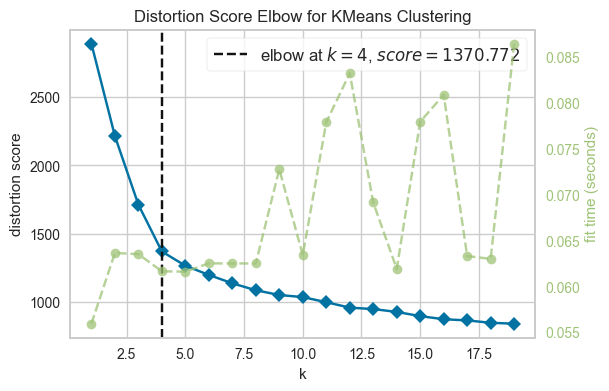

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [105]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(df_kmeans)        # Fit the data to the visualizer
visualizer.show()

- El grafico de codo indica que hay 4 cluster diferenciables.

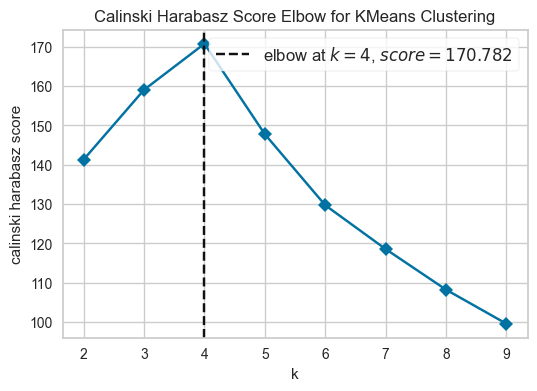

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [106]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='calinski_harabasz', timings=False
)

visualizer.fit(df_kmeans)        # Fit the data to the visualizer
visualizer.show()

- La metrica Calinski-Harabaz indica que hay 4 cluster diferenciables.

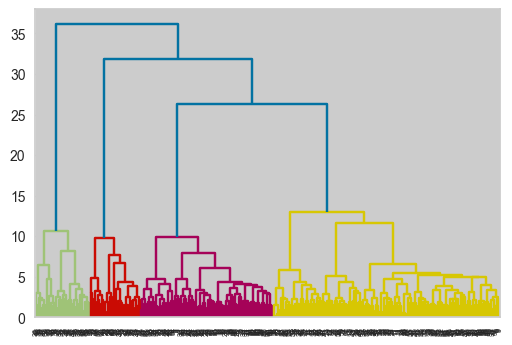

In [107]:
from scipy.cluster.hierarchy import dendrogram ### pintar dendrograma
from sklearn.cluster import AgglomerativeClustering ## Calcular Agrupamiento jerarquico
import scipy.cluster.hierarchy as sch ## DIstancias
plt.rcParams["figure.figsize"] = (6,4)
dendogram=sch.dendrogram(sch.linkage(df_kmeans, method='ward',metric="euclidean"),labels=df_kmeans.index)

- El cluster jerarquico indica que hay 4 clusters diferenciables.

### K-means = 4

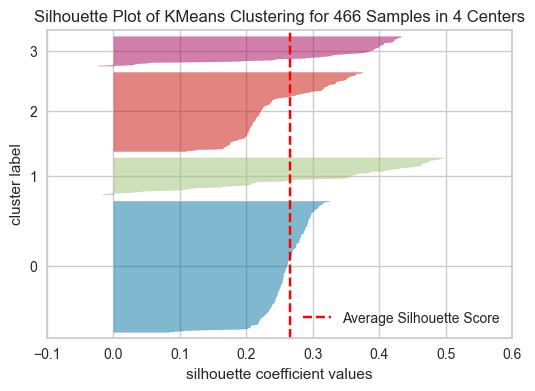

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 466 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, n_init=10, random_state=42))

In [108]:
silhouette_visualizer(KMeans(4, random_state=42, n_init=10), df_kmeans, colors='yellowbrick')

- Con K-Means = 4, se observa que no hay una clara diferenciacion entre grupos, pues se observa que en los segmentos verdes y lilas hay clientes que no estan del todo diferenciados. Por lo tanto, usar 4 grupos o segmentos puede que no sea lo más eficiente.

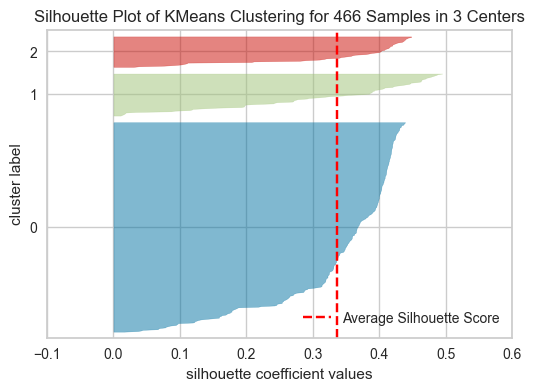

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 466 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=42))

In [109]:
silhouette_visualizer(KMeans(3, random_state=42, n_init=10), df_kmeans, colors='yellowbrick')

- Al probar con 3 segmentos, se observa que estos son mucho más diferenciables entre si, además el indice de silueta es positivo, indicando una buena segmentación de los grupos. En consecuencia, se procedera a realizar la segmentación para 3 grupos.

In [110]:
kmedias = KMeans(n_clusters=3, n_init=10).fit(df_kmeans)

In [111]:
kmedias.labels_

array([1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2,
       0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2,
       0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1,

In [112]:
df_cluster["Grupo"]=kmedias.labels_
df_kmeans["Grupo"] = kmedias.labels_
df_cluster

,BillingCountry,MediaTypeId,Genre,Total,Quantity,Minutes,Avg_Purchase_Frequency,Grupo
CustomerId,,,,,,,,
1,Brazil,1,Latin,10.89,11,3.532618,33.648649,1
1,Brazil,1,Metal,1.98,2,3.646467,33.648649,0
1,Brazil,1,Pop,1.98,2,3.340400,33.648649,0
1,Brazil,1,Reggae,2.97,3,3.565706,33.648649,0
1,Brazil,1,Rock,6.93,7,4.012405,33.648649,0
...,...,...,...,...,...,...,...,...
59,India,1,Latin,3.96,4,4.291150,32.885714,0
59,India,1,Metal,1.98,2,5.204017,32.885714,0
59,India,1,R&B/Soul,3.96,4,3.539908,32.885714,0


In [113]:
# Total comprado
fig = px.box(df_cluster, y="Total", color="Grupo", width=700, height=400)
fig.show()

In [114]:
# Total comprado
fig = px.box(df_cluster, y="Quantity", color="Grupo", width=700, height=400)
fig.show()

In [115]:
# Minutos promedio
fig = px.box(df_cluster, y="Minutes", color="Grupo", width=700, height=400)
fig.show()

In [116]:
# Frecuencia de compra
fig = px.box(df_cluster, y="Avg_Purchase_Frequency", color="Grupo", width=700, height=400)
fig.show()

In [117]:
tabla=df_cluster.groupby(["BillingCountry", "Grupo"]).size()
tabla=tabla.reset_index(name="Conteo")
tabla
fig=px.bar(tabla, x=tabla['BillingCountry'], y=tabla.Conteo, facet_col=tabla.Grupo,)
fig.show()

In [118]:
tabla=df_cluster.groupby(["Genre", "Grupo"]).size()
tabla=tabla.reset_index(name="Conteo")
tabla
fig=px.bar(tabla, x=tabla['Genre'], y=tabla.Conteo, facet_col=tabla.Grupo,)
fig.show()

In [119]:
df_cluster = df_cluster.merge(mediatype_df, how='left', on='MediaTypeId')

In [120]:
tabla=df_cluster.groupby(["Name", "Grupo"]).size()
tabla=tabla.reset_index(name="Conteo")
tabla
fig=px.bar(tabla, x=tabla['Name'], y=tabla.Conteo, facet_col=tabla.Grupo,)
fig.show()

In [121]:
df_cluster.to_parquet("files/segmentation_files/segmentation.parquet")

# Arbol de decisión

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree

X = df_kmeans.drop('Grupo', axis=1)  
y = df_kmeans['Grupo']               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Precisión del modelo: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         8

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94



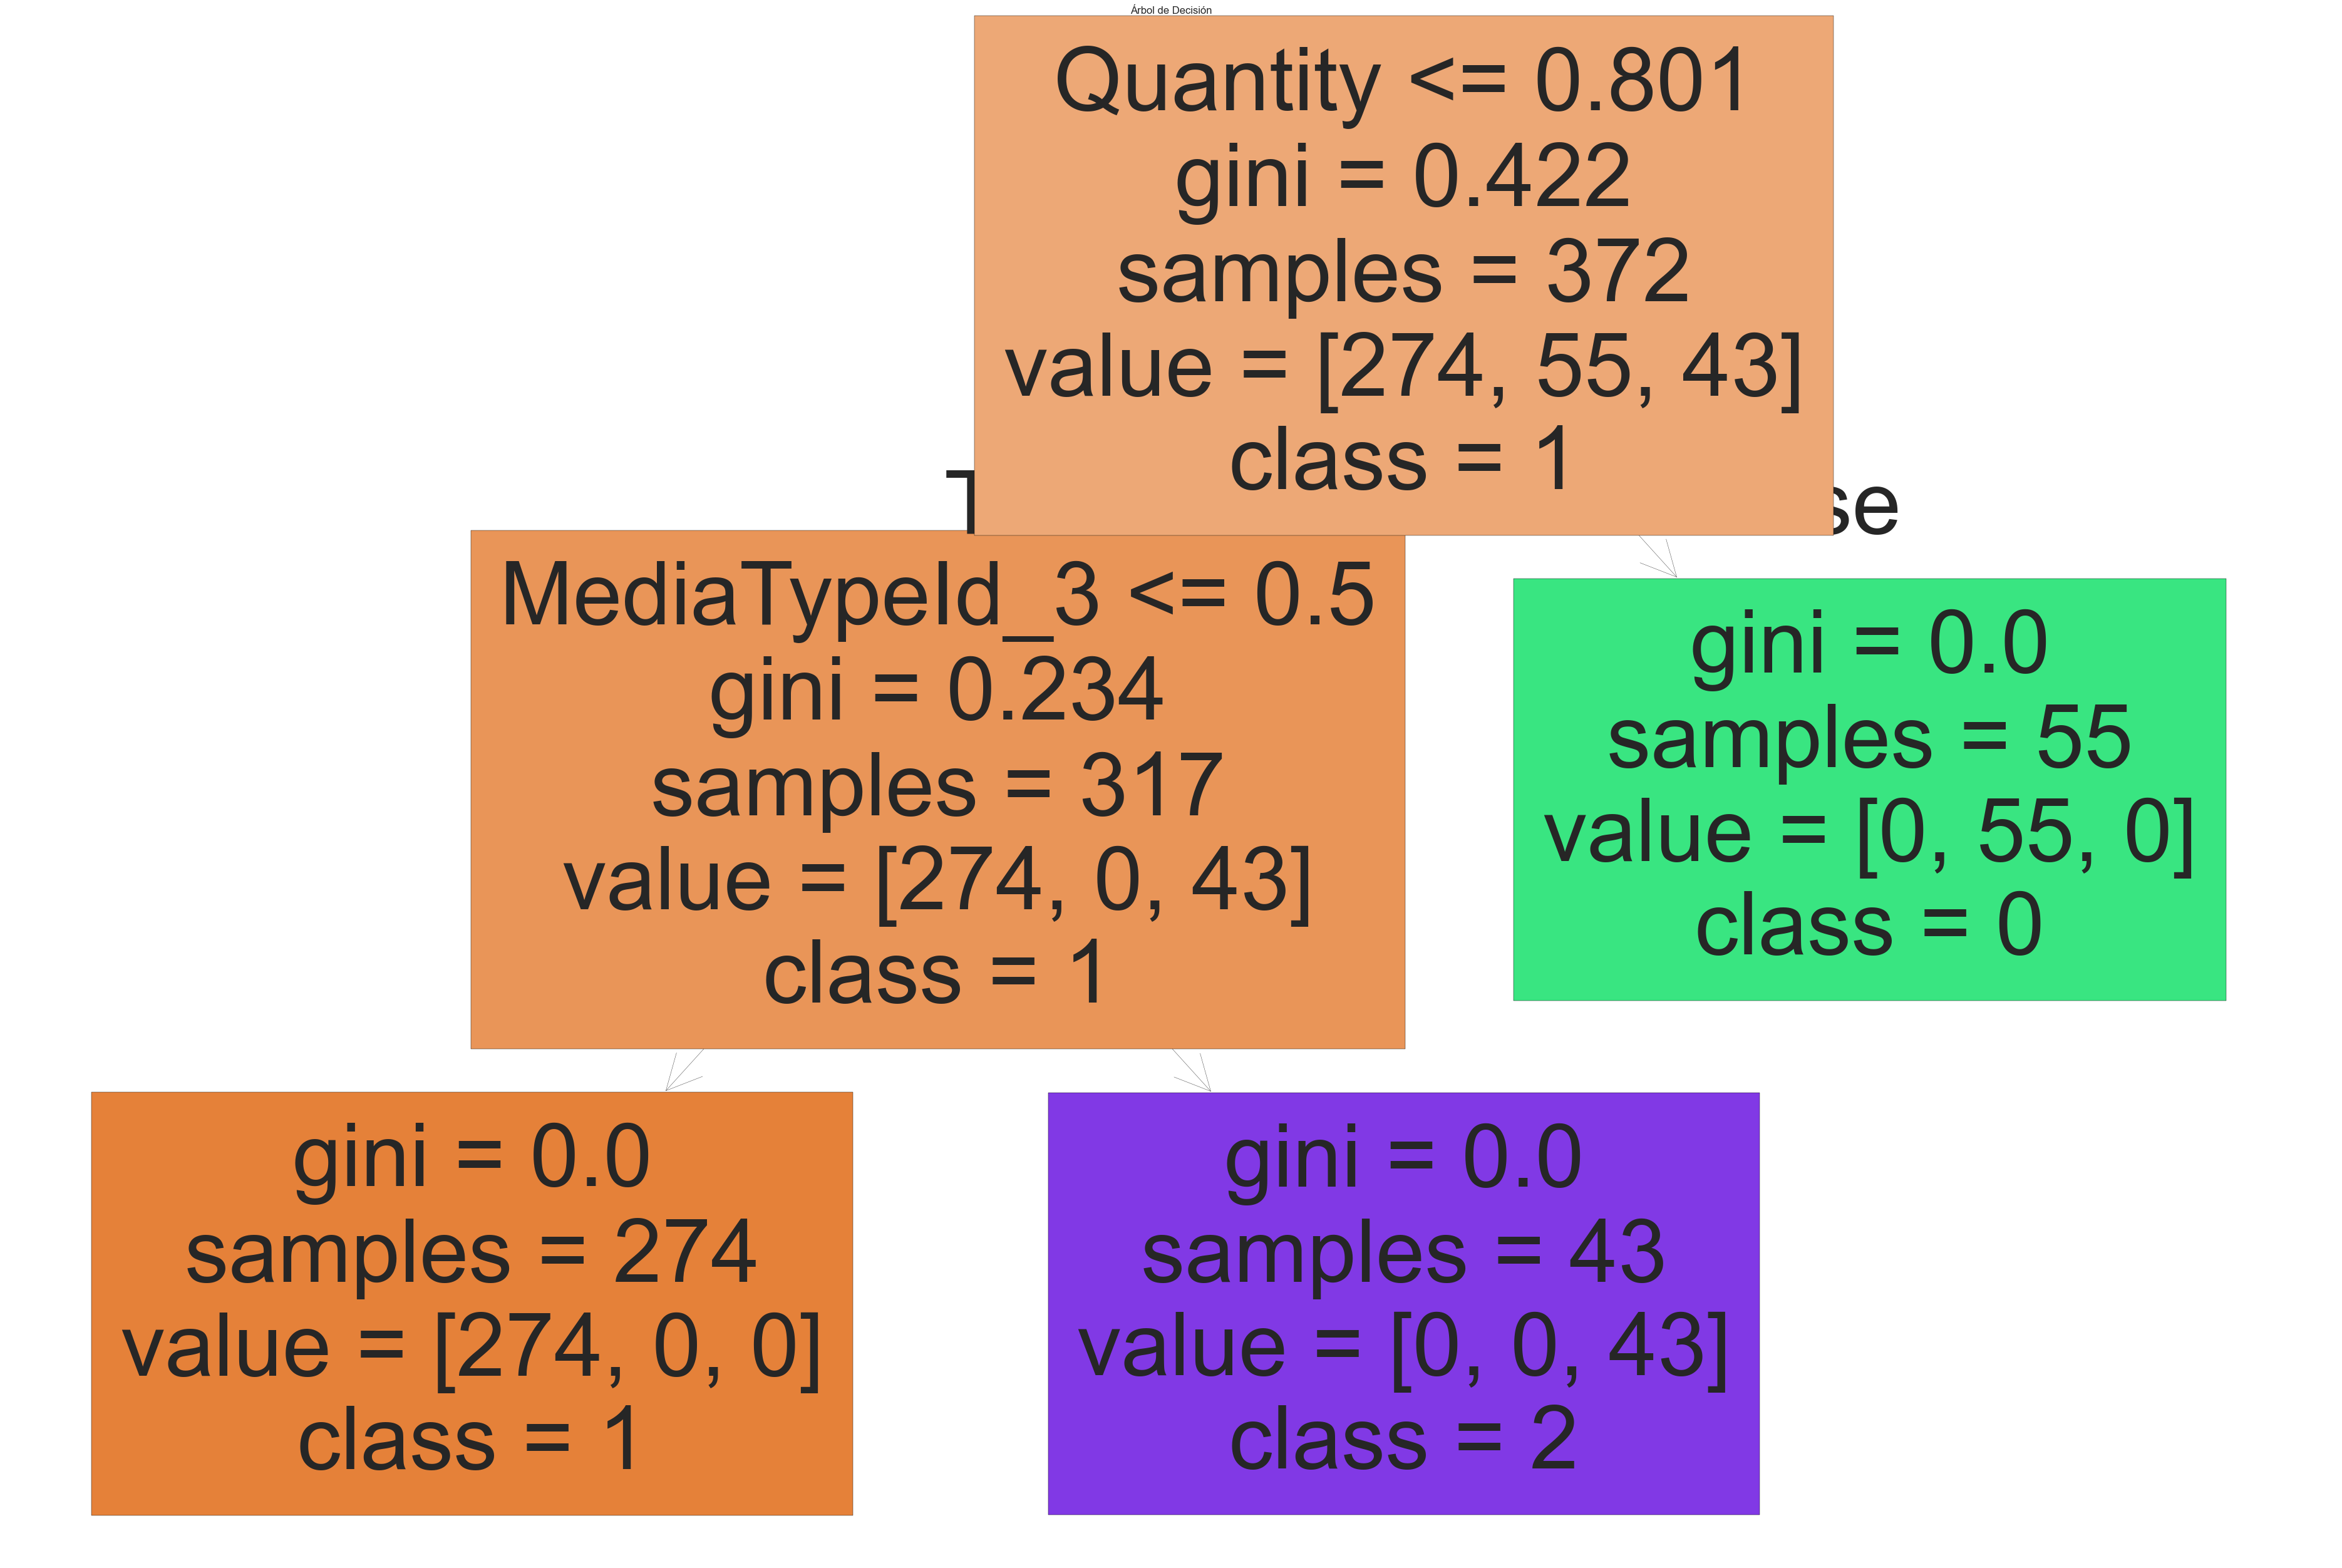

In [123]:
plt.figure(figsize=(48, 32))
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names=y.unique().astype(str))
plt.title("Árbol de Decisión")
plt.savefig("files/segmentation_files/arbol_decision.png", format='png', bbox_inches='tight')
plt.show()